In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [6]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [7]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [8]:
max_steps = 200000
batch_size = 32

In [9]:
lossi = []
losslog10i = []
stepsi = []

In [10]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
    
    break

Loss 0/200000: 3.32205867767334


In [11]:
# We have broken right at the first iteration
# Let's investigate a bit more

In [12]:
# This loss looks better now that we have init the W2 and b2 properly
# but there's still a deeper problem lurking in here
# logits are now okay, the problem now is the value of h, let's explore

In [13]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [14]:
# hard to see but many of the elements are 1 and -1.0
# recall that tanh is a squashing function, takes arbitrary numbers and squashes between -1.0 and 1.0 smoothly
# but the presence of many 1.0 and -1.0 tell us that we're squashing hardly right on the edge, they're getting chopped
# let's look at a histogram

In [15]:
h.shape # 32 examples with 200 activations each, remember it's 200 neuron layer

torch.Size([32, 200])

In [16]:
h.view(-1).shape, len(h.view(-1).tolist()) # stretch out everything in one vector so we can build a histogram

(torch.Size([6400]), 6400)

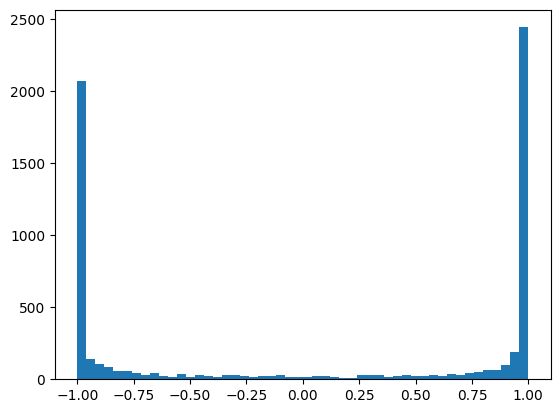

In [17]:
plt.hist(h.view(-1).tolist(), 50); # number of bins

In [18]:
# ZOMG, this looks really bad, you want most stuff inside the tanh range, not on the edges
# cannot explan why, but hopefully we're getting there
# most values are at the edges, tanh is highly activated, why is this happening
# let's look at preact feeding into tanh

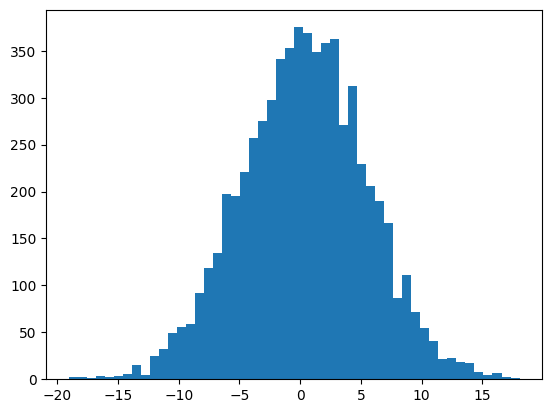

In [19]:
plt.hist(hpreact.view(-1).tolist(), 50); # number of bins

In [20]:
# the pre activation range is very broad, that's why most of the values are getting squashed at the edge
# this might seem innocuous, but once you've grokked* out backprop, gradients flowing and activations
# this will be more clear on why it's a terrible thing

In [21]:
# You're looking at the tanh distribution above and YOU'RE SWEATING
# Let's look at what's happening in the tanh in the backward pass

# Looking at the micrograd code
#    def tanh(self):
#        x = self.data
#        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#        out = Value(t, (self,), 'tanh')
#        
#        def _backward():
#            self.grad += (1 - t**2) * out.grad       <---------- THIS IS THE LINE THAT WE CARE ABOUT
#        
#        out._backward = _backward
#        return out
#

# t is tanh of x, betn. -1 and 1
# in backward, we get the grad by multiplying with 1 - t**2
# What happens when the output of tanh is very close to -1 or 1
# The gradient turns out to be zero from the gradient update
# No matter what the out.grad is, we kill it with the tanh backward
# Effectively tanh acts like a stop gate for backpropagation

# Intuitively : a tanh neuron
# if the output is very close to 1 (or -1), we are at the tail of the tanh
# changing the input a little bit is not going to change tanh output
# because it's already at the edge, flat region of tanh, we can change the input however, but tho tanh output does not change
# SO IT WILL HAVE NO EFFECT ON THE LOSS, AND THE GRADIENT VANISHES

# Similarly when t is exactly 0, the out.grad is just passed through
# tanh is inactive when t is zero, tanh fully blocks when t is [1, -1]
# think of tanh like a faucet that can only decrease thing on backward

In [22]:
# Let's see how often h is in the flat region (say > 0.99)

In [23]:
h.abs().shape

torch.Size([32, 200])

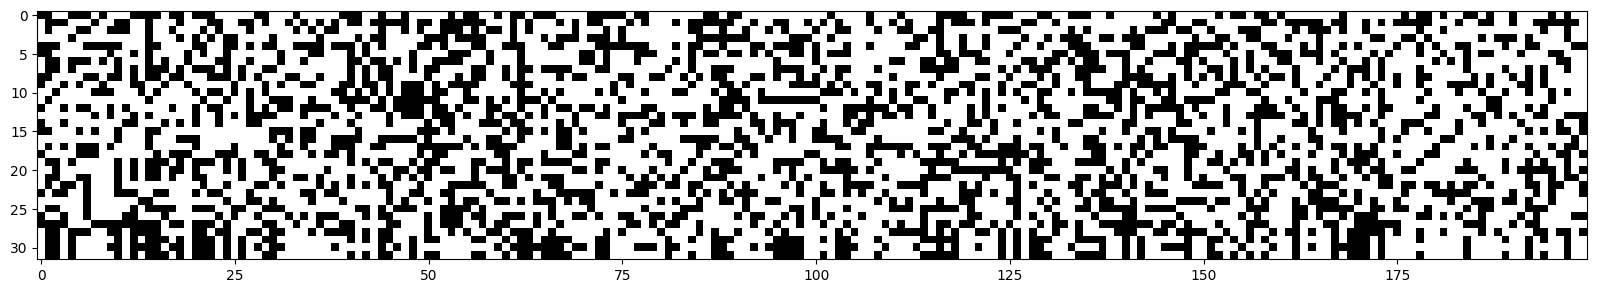

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [25]:
# In all the cases above where true(plotted white), the backward gradient will effectively not flow and/or vanish
# Imagine the trouble we'd be in, if for any of the cases the entire column was white, that's effectively a dead neuron
# That would effectively stop all backpropagation
# Given the weights and biases, imagine that no single example ever activates this tanh
# dead neuron that never learns

# We can see that some gradients will flow for every neuron, there's no dead neuron
# When dead neurons happens, no matter what data you plug in from your dataset, this neuron always fires 1 or -1, no learning happens

In [26]:
# Not just for tanh, but a lot of other non linearities used in NNs
# sigmoid will have the same issue since it's a squashing neuron, just a different range compared to tanh
# same will also apply to relu (if preact is negative, it will effectively not learn) - careful during init
# sometimes too high a learning rate can also get a neuron in a place where
# it gets too much of a gradient, it gets knocked out of data manifold and it'll fire in the flat region, thus becoming dead
# sort of a permanent brain damage

In [27]:
# Let's say you have a NN with Relu neurons, after the training is done, final loss
# then you go through entire training set, forward your examples and find dead neurons that never fire for any examples
# Imagine all the relu neurons learing and flowing in some data manifold
# Because of high LR, they get knocked of this manifold and none of the examples ever get them activated
# Leaky relu won't suffer from it as much (no flat tails)
# ELU might also suffer from this issue as it has flat parts

In [28]:
# Back to the activation map, because there's no single column, we are okay, no dead neuron destroying gradients
# but its not optimal and not something you want, def. not during init
# how do we fix this ?

In [29]:
#    emb = C[Xb]                         # embed the characters into vectors
#    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#    hpreact = embcat @ W1 + b1          # hidden layer pre-activation

# embcat comes from C which is gaussian, but then it's mult with W1 & b1
# hpreact gets too far off from zero causing the issue

# so we need to do the same thing for W1 and b1 as we did for W2 and b2
# bias can be set to zero for init, but can also be multiplied by 0.001 etc. so there's some entropy, diversity

# lets do that an inspect after the first iteration again

In [30]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [31]:
max_steps = 200000
batch_size = 32

In [32]:
lossi = []
losslog10i = []
stepsi = []

In [33]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
    
    break

Loss 0/200000: 3.3134593963623047


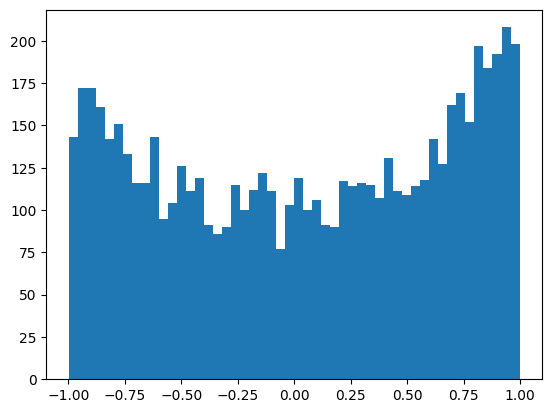

In [34]:
plt.hist(h.view(-1).tolist(), 50); # number of bins - this is not hpreact

In [35]:
# Looks brilliant, this is what we want tanh output to look like

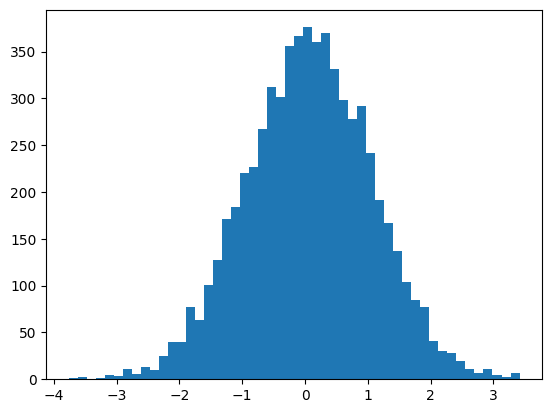

In [36]:
plt.hist(hpreact.view(-1).tolist(), 50); # number of bins

In [37]:
# and the preact values are well with a good range

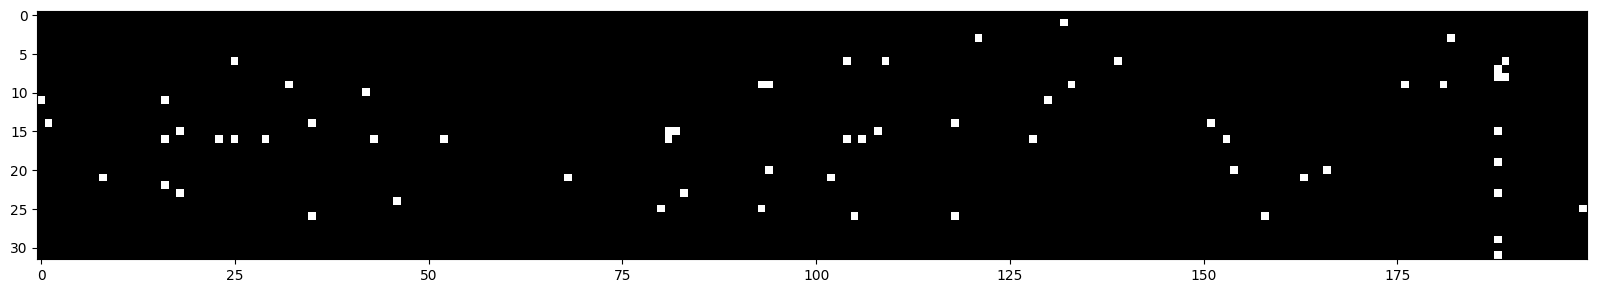

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [39]:
# only some white pixel
# this is a pretty decent place to be

# Let's run the full optimization

In [40]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [41]:
max_steps = 200000
batch_size = 32

In [42]:
lossi = []
losslog10i = []
stepsi = []

In [43]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3134593963623047
Loss 20000/200000: 2.3060874938964844
Loss 40000/200000: 1.9786770343780518
Loss 60000/200000: 2.4232332706451416
Loss 80000/200000: 2.3095450401306152
Loss 100000/200000: 1.8268601894378662
Loss 120000/200000: 1.9796521663665771
Loss 140000/200000: 2.1000454425811768
Loss 160000/200000: 1.8619437217712402
Loss 180000/200000: 1.9672837257385254


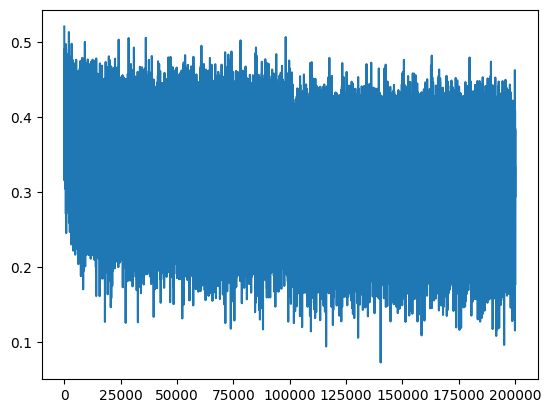

In [44]:
plt.plot(stepsi, losslog10i)

In [45]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.0355963706970215
val loss : 2.1026782989501953


In [46]:
# And the losses have improved even a bit further after fixing the tanh saturation

In [47]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.


In [48]:
# Note our losses going down with tricks

# Train test validation split - in the beginning
# Train Loss : 2.2589
# Val Loss   : 2.2702

# After increasing NN capacity and embedding size
# Train Loss : 2.1190
# Val Loss   : 2.1711

# After fixing init weight bias softmax confidently wrong
# Train loss : 2.0695
# Val loss : 2.1310

# Now, after fixing tanh saturation
# train loss : 2.0355
# val loss : 2.1026

In [49]:
# Since it's the same number of iterations exactly from the beginning of training
# We can see that we are spending more time training to get better
# rather than spend time squashing weights

In [50]:
# This illustrates initialization and its impact on performance
# just by being aware of internal states of the NN, the activations and the gradients

In [51]:
# this is a shallow network, so the optimisation problem is easy and forgiving
# even though our init was terrible, the network eventually learnt
# but this is not the case in general
# once we start working with much deeper networks (say 50 layers), things can get much more complicated
# these problems stack up and you can get into a place where the network doesn't train at all
# the deeper your network and the more complex it is, the less forgiving it is to some of these init issues

In [52]:
# Something to scrutinize, plot and be careful